In [17]:
from __future__ import print_function, division

import torch
print(torch.version.cuda)
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode
import cv2
%matplotlib inline

9.0


In [3]:
# Data augmentation and normalization for training
# Just normalization for valation
input_size = 224
resize = 224
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(resize),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(resize),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = r'adoption_folders'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],batch_size=128,#4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 43659
    Root Location: adoption_folders\train
    Transforms (if any): Compose(
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [5]:
class_names

['0', '1', '2', '3', '4']

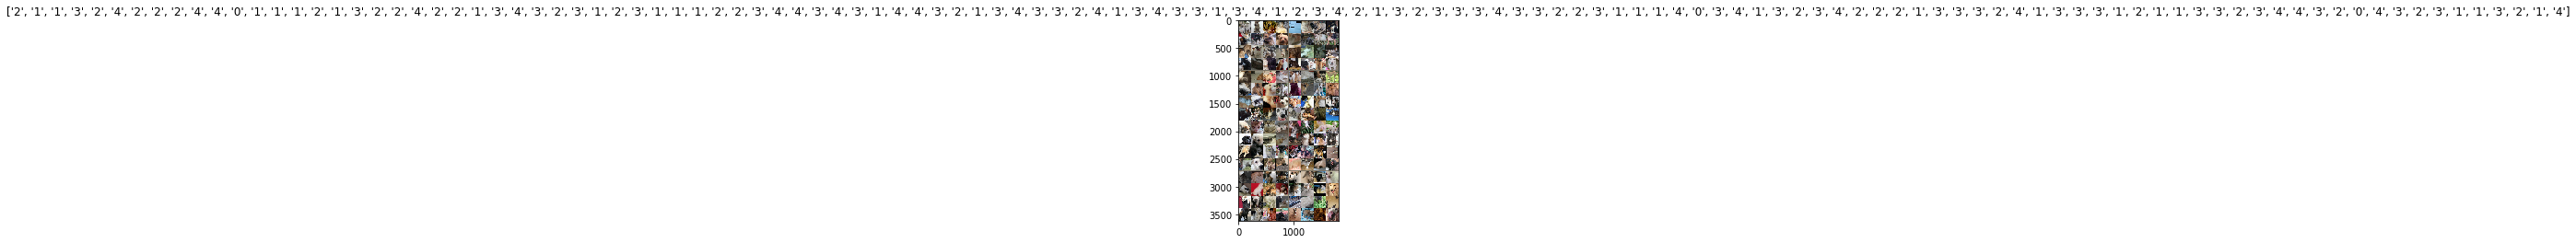

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and valation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                print(type(labels))# = float(labels)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [3]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    #set_trace()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(inputs.shape, outputs.shape)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]])+'\nTrue: {}'.format(class_names[labels.cpu().data[j]]))
                imshow(inputs.cpu().data[j])
                
                #cv2.imwrite('out.png',inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_ft = models.resnet18(pretrained=True) #False) #
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)
#model_ft = model_newinput.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)#5)

Epoch 0/1
----------
train Loss: 1.4364 Acc: 0.3163
val Loss: 1.4600 Acc: 0.2871

Epoch 1/1
----------
train Loss: 1.3707 Acc: 0.3700
val Loss: 1.4209 Acc: 0.3407

Training complete in 7m 27s
Best val Acc: 0.340704


In [10]:

visualize_model(model_ft)
plt.ioff()
plt.show()

NameError: name 'model_2' is not defined

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 1.3312 Acc: 0.4031
val Loss: 1.4491 Acc: 0.3212

Epoch 1/19
----------
train Loss: 1.2857 Acc: 0.4358
val Loss: 1.4249 Acc: 0.3517

Epoch 2/19
----------
train Loss: 1.2267 Acc: 0.4782
val Loss: 1.4480 Acc: 0.3496

Epoch 3/19
----------
train Loss: 1.1491 Acc: 0.5264
val Loss: 1.4726 Acc: 0.3526

Epoch 4/19
----------
train Loss: 1.0439 Acc: 0.5864
val Loss: 1.5426 Acc: 0.3464

Epoch 5/19
----------
train Loss: 0.8838 Acc: 0.6866
val Loss: 1.5358 Acc: 0.3538

Epoch 6/19
----------
train Loss: 0.8581 Acc: 0.6992
val Loss: 1.5459 Acc: 0.3535

Epoch 7/19
----------
train Loss: 0.8353 Acc: 0.7084
val Loss: 1.5655 Acc: 0.3540

Epoch 8/19
----------
train Loss: 0.8117 Acc: 0.7204
val Loss: 1.5817 Acc: 0.3535

Epoch 9/19
----------


KeyboardInterrupt: 

In [7]:
# Data augmentation and normalization for training
# Just normalization for valation
input_size = 224#512
resize = 224#512
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(resize),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(resize),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = r'adoption_folders'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],batch_size=1,#64,#128,#4,
                                             shuffle=True
                                             # , num_workers=4
                                             )
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

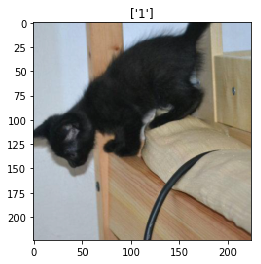

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
model_2 = models.resnet18(pretrained=True)
model_2.avgpool=nn.AvgPool2d(7,stride=1) #(33,12), stride=1)
#model_2.avgpool=nn.AvgPool2d((16,16), stride=1)
model_2.fc = nn.Linear(512,len(class_names))
model_2 = model_2.to(device)
#model_ft = model_newinput.to(device)
criterion = nn.MSELoss()#CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_2, step_size=7, gamma=0.1)
model_2 = train_model(model_2, criterion, optimizer_2, exp_lr_scheduler,
                       num_epochs=7)

Epoch 0/6
----------
<class 'torch.Tensor'>


RuntimeError: Expected object of scalar type Float but got scalar type Long for argument #2 'target'

In [18]:
train_df = pd.read_csv(r'./input/petfinder-adoption-prediction/train/train.csv')
test_df = pd.read_csv(r'./input/petfinder-adoption-prediction/test/test.csv')
test_df['AdoptionSpeed'] = [-1] * len(test_df)
data_df = pd.concat([train_df, test_df], axis=0).reset_index()
print(train_df.shape[0], test_df.shape[0], data_df.shape[0])

14993 3948 18941


In [14]:
os.mkdir(r'./adoption_folders_k/')

In [20]:
#os.mkdir(r'./adoption_folders_k/train/')
#os.mkdir(r'./adoption_folders_k/valid/')
for i in set(data_df['AdoptionSpeed'].values):
    print(i)
    if i>=0:
        os.mkdir(r'./adoption_folders_k/train/'+str(i))
        os.mkdir(r'./adoption_folders_k/valid/'+str(i))

0
1
2
3
4
-1
